# Amazon Reviews Analysis and Modelling Using BERT

# 1. Install and Import Necessary Libray For NLP and Sentiment Analysis

In [1]:
%%capture
!pip install stopwords
!pip install flair
!pip install nltk
!pip install swifter

In [2]:
!pip install --upgrade pyarrow

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random as rn
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

pd.options.display.max_rows = None
seed=40

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# 2. Import Amazon Reviews Dataset

### Here i'm just taking 10% of our data to analyze and to be trained.

In [4]:
rn.seed(a=40)
p = 0.1
review = pd.read_csv('../input/amazon-product-reviews/Reviews.csv',skiprows=lambda i: i>0 and rn.random() > p)
review.shape

(56733, 10)

In [5]:
review.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
1,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
2,26,B001GVISJM,A3FONPR03H3PJS,"Deborah S. Linzer ""Cat Lady""",0,0,5,1288310400,Twizzlers - Strawberry,Product received is as advertised.<br /><br />...
3,41,B001EO5QW8,AQCY5KRO7489S,Garrett,0,0,5,1303430400,Why wouldn't you buy oatmeal from Mcanns? Tast...,The variety packs taste great!<br /><br />I ha...
4,45,B001EO5QW8,A2G7B7FKP2O2PU,D. Leschke,0,0,5,1209686400,Great taste and convenience,We really like the McCann's steel cut oats but...


### Here i will group the scores into positive and negative sentiment

In [6]:
def score_round(x):
    if x>=3:
        return 1
    else: 
        return 0

In [7]:
review['review_score']= review.Score.apply(score_round)

In [8]:
review = review.rename(columns={'Text':'review_text'})

In [9]:
# review.review_score.replace("positive" , 1 , inplace = True)
# review.review_score.replace("negative" , 0 , inplace = True)

### Here i'm taking 80% of our data to be used as our model validation in case needed.

In [10]:
rn.seed(a=40)
q = 0.8 
review_val = pd.read_csv('../input/amazon-product-reviews/Reviews.csv',skiprows=lambda i: i>0 and rn.random() > q)
review_val.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
2,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
3,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
4,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...


In [11]:
review_val['review_score']=review_val.Score.apply(score_round)

In [12]:
review_val = review_val.rename(columns={'Text':'review_text'})

In [13]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56733 entries, 0 to 56732
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      56733 non-null  int64 
 1   ProductId               56733 non-null  object
 2   UserId                  56733 non-null  object
 3   ProfileName             56731 non-null  object
 4   HelpfulnessNumerator    56733 non-null  int64 
 5   HelpfulnessDenominator  56733 non-null  int64 
 6   Score                   56733 non-null  int64 
 7   Time                    56733 non-null  int64 
 8   Summary                 56729 non-null  object
 9   review_text             56733 non-null  object
 10  review_score            56733 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 4.8+ MB


### Here i'm making sure that our text review data type is string

In [14]:
review.review_text = review.review_text.astype('str')
review_val.review_text = review.review_text.astype('str')

review.Summary = review.Summary.astype('str')
review_val.Summary = review.Summary.astype('str')

# 3. Analysis and Visualization

## 3.1. Distribution of Reviews in Each Sentiment

In [15]:
temp = review.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_text',ascending=False)
temp.style.background_gradient(cmap='Purples')


,review_score,review_text
1,1,48531
0,0,8202


### We will see the visualization of it.

<AxesSubplot:xlabel='review_score', ylabel='count'>

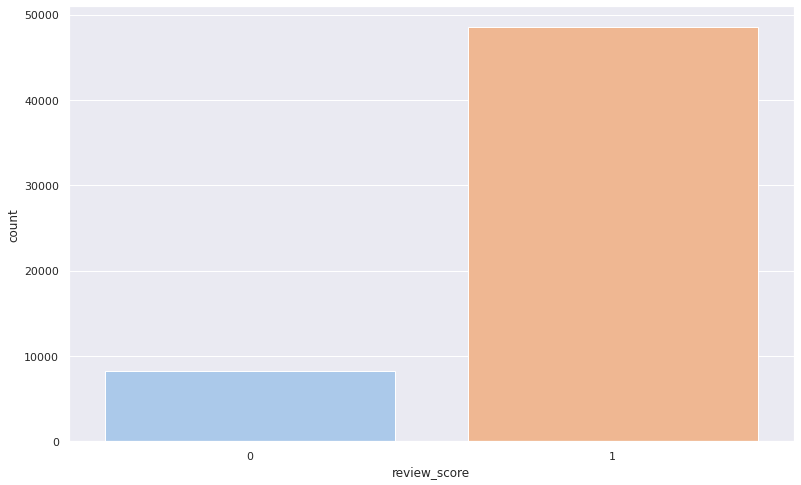

In [16]:
sns.set_theme(style='whitegrid')
sns.set(rc = {'figure.figsize':(13,8)})
sns.set_palette("pastel")
sns.countplot(x='review_score',data=review)

### We can see that there are more positive sentiment reviews than negative sentiment reviews.

## 3.2. WordCloud of Our Review Text

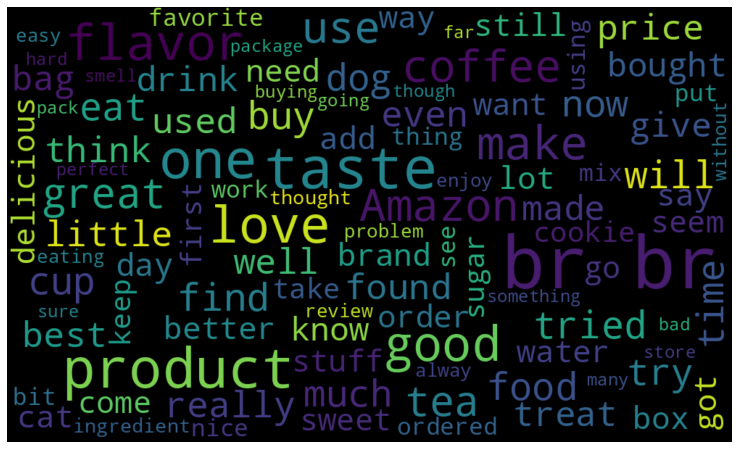

In [17]:
txt = ' '.join(rev for rev in review.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

## 3.3. WordCloud of Each Sentiment Review

In [18]:
positive = review[review['review_score']==1]
negative = review[review['review_score']==0]

## Positive Sentiment Text and Summary Reviews

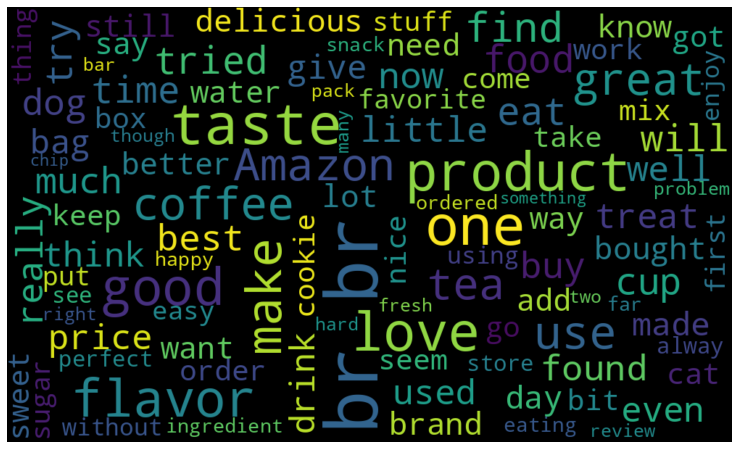

In [19]:
txt = ' '.join(rev for rev in positive.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

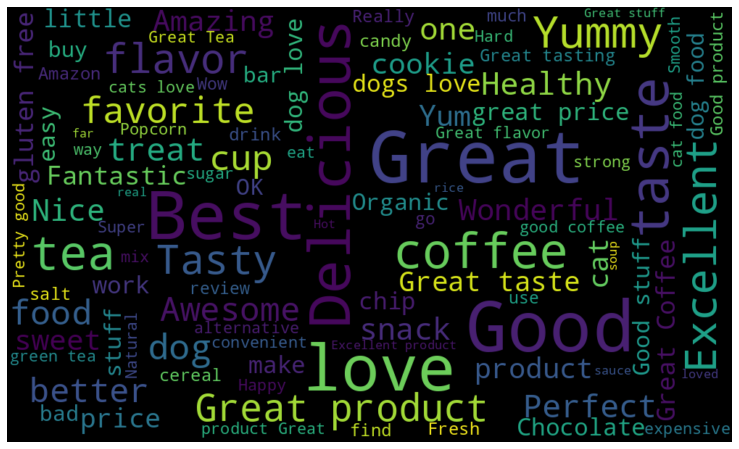

In [20]:
txt = ' '.join(rev for rev in positive.Summary)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### We can see that for postive sentiment review, the most common words are 'good', 'tasty', 'great', 'love' , etc as shown in picture above.

## Negative Sentiment Reviews

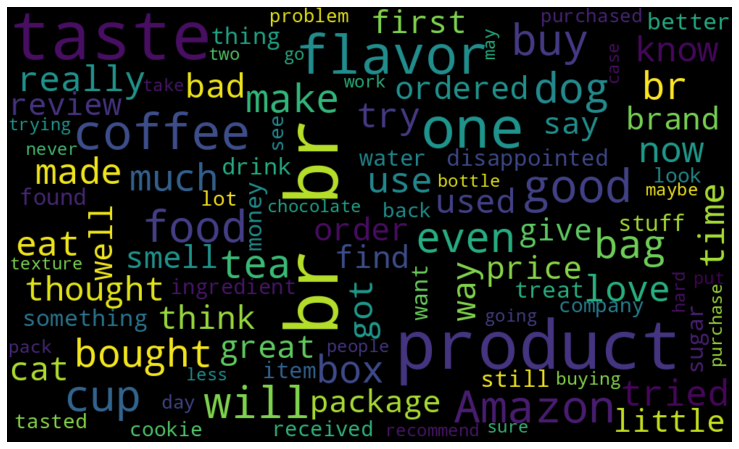

In [21]:
txt = ' '.join(rev for rev in negative.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

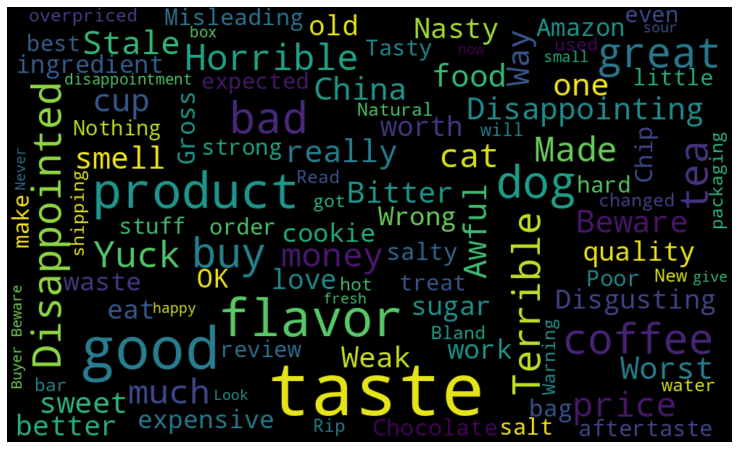

In [22]:
txt = ' '.join(rev for rev in negative.Summary)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### And we can see that for negative sentiment review, the most common words are 'taste', 'disappointing', 'disappointed', 'Horrible', etc as shown in picture above.

## 3.4. Distribution of Number of Review Words

### First we create additional features to count number of words in each review text

In [23]:
review_vis = review.copy()

In [24]:
review_vis['Num_word_review'] = review_vis['review_text'].apply(lambda x:len(str(x).split()))

### Than we can plot them

<AxesSubplot:xlabel='Num_word_review', ylabel='Count'>

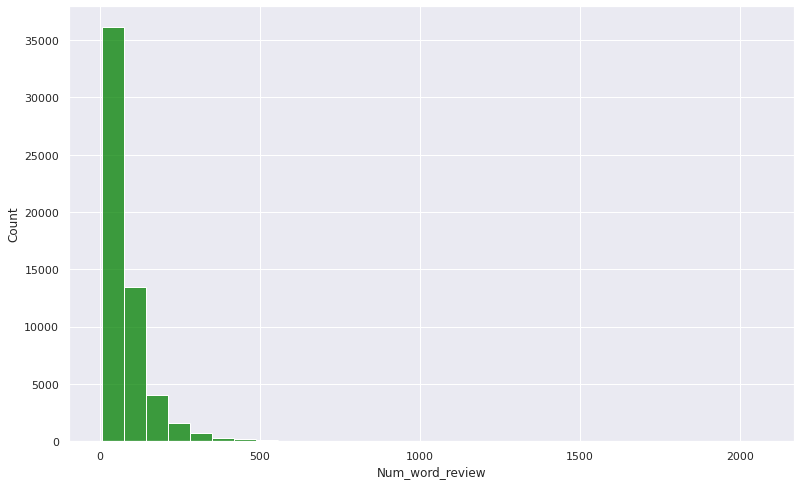

In [25]:
sns.histplot(data=review_vis, x="Num_word_review",bins=30,color='green')

### As we can see that most of our review texts contain 1-300 words.

## 3.5. Distribution of Words in All Review Texts

In [26]:
review_vis['temp_list'] = review_vis['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,162221
1,I,138371
2,and,122481
3,a,115814
4,to,98518
5,of,78365
6,is,71102
7,it,62483
8,for,52010
9,in,50791


### Of course this list still contains stopwords which we have not filtered yet. We will see them later after we filter our review texts.

# 4. Data Cleaning For Sentiment Processing

In [27]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Null values Cleaning

In [28]:
review.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               2
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
review_text               0
review_score              0
dtype: int64

### But after we've seen that the missing values are only in profile name feature, we will ignore them anyway.

### Duplicate Values Removing

In [29]:
review = review.drop_duplicates(keep='first')

In [30]:
review.shape

(56733, 11)

### We make a function to clean some basic characters

In [31]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

### We make function to remove numeric

In [32]:
def remove_num(texts):
    output = re.sub(r'\d+', '', texts)
    return output

### We make function to remove emoji

In [33]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

### We make function to unify whitespaces

In [34]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

### We make function to remove symbols

In [35]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

### We make function to remove punctuation

In [36]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

### We make function to remove stopwords

In [37]:
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
    text=[word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

### We make function to use stemming to normalize words

In [38]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
def Stemming(text):
    stem=[]
    stopword = stopwords.words('english')
    snowball_stemmer = SnowballStemmer('english')
    word_tokens = nltk.word_tokenize(text)
    stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
    stem=' '.join(stemmed_word)
    return stem

### Then we combine all the cleaning functions

In [39]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)

In [40]:
cleaning(review,'review_text')

In [41]:
review.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               2
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
review_text               0
review_score              0
dtype: int64

In [42]:
review[['review_text']].head(20)

,review_text
0,confection around centuries light pillowy citr...
1,know cactus tequila unique combination ingredi...
2,product received advertised br br link
3,variety packs taste great br br every morning ...
4,really like mccann steel cut oats find cook of...
5,stuff buy big box stores nothing healthy carbs...
6,great product nice combination chocolates perf...
7,halloween sent bag daughters class share choco...
8,purchased mango flavor take like mango hint sw...
9,peppermint stick delicious fun eat dad got one...


### Now all the cleanings are done. We will try to visualize the common words distribution of our review texts. We have done it before but our previous review texts still contain stopwords and punctuations.

In [43]:
review_vis2 = review.copy()

In [44]:
review_vis2['temp_list'] = review_vis2['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis2['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,br,63179
1,like,25623
2,good,20004
3,taste,17342
4,one,17231
5,great,16743
6,coffee,16248
7,product,15012
8,flavor,14743
9,tea,13534


### We can plot them

<AxesSubplot:xlabel='count', ylabel='Common_words'>

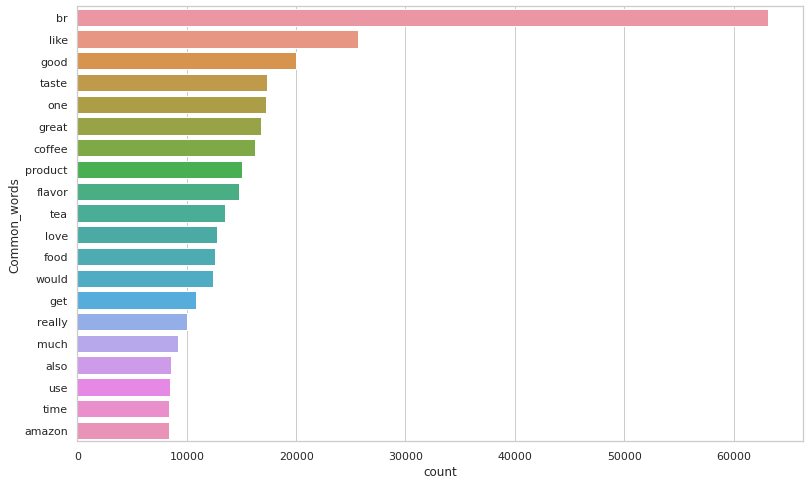

In [45]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp)

### Then We can see that the word "br" , "like" , "good" are the top 3 common words in our review texts.

# 5. BERT Tokenizing and Modelling

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tokenizers import BertWordPieceTokenizer

import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

import logging
transformers.logging.set_verbosity_error()


## 5.1. We Split Our Data to Training, Validation, and Hold-Out Data

In [47]:
reviews = review["review_text"].values.tolist()
labels = review["review_score"].tolist()

In [48]:
# split the dataset into train, validation and holdout sets (60-20-20)
training_sentences, test_sentences, training_labels, test_labels = train_test_split(reviews, labels, test_size=.4)

validation_sentences, holdout_sentences, validation_labels, holdout_labels = train_test_split(test_sentences, test_labels, test_size=.5)

In [49]:
training_labels = pd.Series(training_labels)

In [50]:
num_rows_to_shuffle = int(0.2 * len(training_labels))
np.random.seed(0)  
indices_to_flip = np.random.choice(training_labels.index[1:], size=num_rows_to_shuffle, replace=False)
training_labels.iloc[indices_to_flip] = 1 - training_labels.iloc[indices_to_flip] #Single flip

## 5.2. We Tokenize Our Input Data

In [51]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [52]:
# Example of the tokenizer output
tokenizer([training_sentences[0]], truncation=True,
                            padding=True, max_length=512)

{'input_ids': [[101, 3687, 2944, 3987, 11515, 1774, 2195, 11019, 16274, 1162, 9050, 16852, 1253, 7634, 2033, 11019, 16274, 1162, 16320, 4427, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [53]:
# We tokenize training, validation and hold-out Texts

train_encodings = tokenizer(training_sentences,
                            truncation=True,
                            padding=True)

validation_encodings = tokenizer(validation_sentences,
                            truncation=True,
                            padding=True)

holdout_encodings = tokenizer(holdout_sentences,
                            truncation=True,
                            padding=True)

In [54]:
# We convert the input encodings and labels into a TensorFlow Dataset object

train_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(train_encodings),
                            training_labels
                            ));

validation_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(validation_encodings),
                            validation_labels
                            ));

holdout_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(holdout_encodings),
                            holdout_labels
                            ));

## 5.3. BERT Model Fine-Tuning

In [55]:
import json

class SaveResultsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        with open(f'results_epoch_{epoch}.json', 'w') as f:
            json.dump(logs, f)

In [56]:
# We initialize our pre-trained BERT model

model = TFBertForSequenceClassification.from_pretrained('bert-base-cased',num_labels=2)

In [57]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

In [58]:
# We train and fine tune our pre-trained BERT model

history = model.fit(train_dataset.shuffle(100).batch(8),
          epochs=1,
          batch_size=8,
          validation_data=validation_dataset.shuffle(100).batch(8),
                    callbacks=[SaveResultsCallback()],verbose=1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:376: FutureWarning: The old compute_loss method is deprecated as it conflicts with the Keras compute_loss method added in TF 2.8. If you want the original HF compute_loss, please call hf_compute_loss() instead. From TF versions >= 2.8, or Transformers versions >= 5, calling compute_loss() will get the Keras method instead.
  return py_builtins.overload_of(f)(*args)


4255/4255 [==============================] - 4480s 1s/step - loss: 0.5852 - accuracy: 0.7181 - val_loss: 0.4680 - val_accuracy: 0.8567


In [59]:
# Save the model
model.save_pretrained("./bert_base_cased_model")

# Save the tokenizer if you've used a specific one
tokenizer.save_pretrained("./bert_base_cased_model")

('./bert_base_cased_model/tokenizer_config.json',
 './bert_base_cased_model/special_tokens_map.json',
 './bert_base_cased_model/vocab.txt',
 './bert_base_cased_model/added_tokens.json')

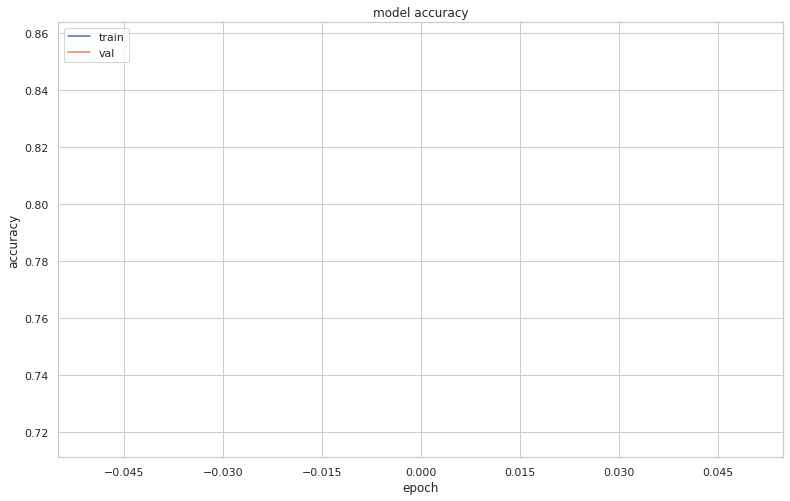

In [60]:
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [61]:
model.save_pretrained("./output_model")

## 5.4. BERT Model's Performance Evaluation

In [62]:
'''from transformers import TFBertForSequenceClassification, BertTokenizer

# Load the model
loaded_model = TFBertForSequenceClassification.from_pretrained("./bert_large_cased_model")

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained("./bert_large_cased_model")'''

'from transformers import TFBertForSequenceClassification, BertTokenizer\n\n# Load the model\nloaded_model = TFBertForSequenceClassification.from_pretrained("./bert_large_cased_model")\n\n# Load the tokenizer\ntokenizer = BertTokenizer.from_pretrained("./bert_large_cased_model")'

In [63]:
# We load the model and then evaluate it on holdout set

loaded_model = TFBertForSequenceClassification.from_pretrained("./output_model")
result = model.evaluate(holdout_dataset.batch(8))
dict(zip(model.metrics_names, result))

1419/1419 [==============================] - 469s 330ms/step - loss: 0.4680 - accuracy: 0.8567


{'loss': 0.46800872683525085, 'accuracy': 0.8567022085189819}

### We got our model's accuracy 91.26% on our holdout set (other validation set)

In [64]:
# Then we predict the sentiment for holdout set

tf_output = loaded_model.predict(holdout_dataset.batch(8))
pred_label = tf.argmax(tf.nn.softmax(tf_output["logits"], axis=1).numpy(), 1).numpy()

In [65]:
# After that we create the confusion matrix of our predictions

cm = tf.math.confusion_matrix(
    holdout_labels, pred_label, num_classes=2, weights=None, dtype=tf.dtypes.int32,
    name=None
).numpy()

print("confusion matrix\n",cm)

confusion matrix
 [[   0 1626]
 [   0 9721]]


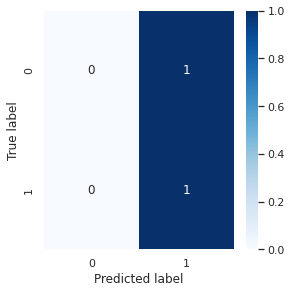

In [66]:
# We can visualize the confusion matrix

cm_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

cm_df = pd.DataFrame(cm_norm,
                 index = [0,1], 
                 columns =[0,1])

figure = plt.figure(figsize=(4, 4))
sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


### Our dataset is highly imbalanced, we need other metrics to see how good our model is based on our confusion matrix.

In [67]:
# Precision, Recall, and F1-Score

tp = cm[0][0]
fn = cm[0][1]

tn = cm[1][1]
fp = cm[1][0]

recall = round(tp / (tp+fn), 2)
precision = round(tp / (tp+fp), 2)
f1score = (2*precision*recall) / (precision + recall)

print("recall score:", recall)
print("precision score:", precision)
print("F1-Score:",f1score)

recall score: 0.0
precision score: nan
F1-Score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in int_scalars
  # Remove the CWD from sys.path while we load stuff.


### Then we got our model's score with f1-score of 0.709. It is not bad but it's not too good either. We can improve our model's performance by using other text cleaning method like stemming (which i haven't used it here) and we also can tune our BERT model parameters.